In [1]:
import ROOT as rt

Welcome to JupyROOT 6.30/04


In [2]:
load_path = "workspace/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat20.root"

In [3]:
file = rt.TFile.Open(load_path)

In [4]:
canvas = rt.TCanvas()
canvas.cd()
mass =  rt.RooRealVar("mh_ggh","mass (GeV)",100,81,101)
mass.setBins(100) # set bins to make fitting quicker 
frame = mass.frame()

In [5]:

bwWidth = rt.RooRealVar("bwz_Width" , "widthZ", 2.5, 0, 30)
bwmZ = rt.RooRealVar("bwz_mZ" , "mZ", 91.2, 90, 92)
sigma = rt.RooRealVar("sigma" , "sigma", 2, 0.0, 5.0)

bwWidth.setConstant(True)
bwmZ.setConstant(True)
# sigma.setConstant(True)
#bwmZ.setConstant(True)

model1 = rt.RooVoigtian("Voigtian" , "Voigtian",mass, bwmZ, bwWidth, sigma)

exp_coeff = rt.RooRealVar("exp_coeff", "exp_coeff", 0.01, 0.00000001, 1) # positve coeff to get the peak shape we want 
# exp_coeff = rt.RooRealVar("exp_coeff", "exp_coeff", -0.1, -1, -0.00000001) # negative coeff to get the peak shape we want 
shift = rt.RooRealVar("shift", "Offset", 85, 75, 105)
shifted_mass = rt.RooFormulaVar("shifted_mass", "@0-@1", rt.RooArgList(mass, shift))
model2_1 = rt.RooExponential("Exponential", "Exponential", shifted_mass,exp_coeff)

erfc_ccenter = rt.RooRealVar("erfc_ccenter" , "erfc_ccenter", 91.2, 75, 105)
erfc_coeff = rt.RooRealVar("erfc_coeff" , "erfc_coeff", 0.1, 0, 1.5)
erfc_in = rt.RooFormulaVar("erfc_in", "(@0 - @2) * @1", rt.RooArgList(mass, erfc_coeff, erfc_ccenter)) 
# both bindPdf and RooGenericPdf work, but one may have better cuda integration over other, so leaving both options
# model2_2 = rt.RooFit.bindPdf("erfc", rt.TMath.Erfc, erfc_in)
model2_2 = rt.RooGenericPdf("erfc", "TMath::Erfc(@0)", erfc_in)


# model2_2 = rt.RooGenericPdf("erfc", "TMath::Erf(@0)+1", erfc_in)
# model2_2 = rt.RooFit.bindFunction("erfc", rt.TMath.Erf, erfc_in)




model2 = rt.RooProdPdf("erfc_exp", "erfc_exp", rt.RooArgList(model2_1, model2_2))
sigfrac = rt.RooRealVar("sigfrac", "sigfrac", 0.9, 0, 1.0)
model3 = rt.RooAddPdf("model3", "model3", rt.RooArgList(model1, model2),rt.RooArgList(sigfrac))

# For Val: ignore this dummy_bkg_var. This is just so I could plot bkg plot proportional to its fraction, which doesn't work
# bkgfrac = rt.RooFormulaVar("bkgfrac", "(1 - @0)", rt.RooArgList(sigfrac)) 
# dummy_bkg_var = rt.RooProdPdf("dummy_bkg_var", "dummy_bkg_var", rt.RooArgList(bkgfrac, model2))  # pdf model just for plotting bkg on the plot with bkgfrac
dummy_bkg_var = rt.RooGenericPdf("dummy_bkg_var", "dummy_bkg_var", "(1 - @0) * @1", rt.RooArgList(sigfrac,model2))

In [6]:
erfc_coeff.Print()

RooRealVar::erfc_coeff = 0.1  L(0 - 1.5) 


In [7]:
import time

start = time.time()
roo_dataset = file.w.data("data_Zfit_no_e_cut_UL_calib_cat20")
roo_hist = rt.RooDataHist("data_hist","binned version of roo_dataset", rt.RooArgSet(mass), roo_dataset)  # copies binning from mass variable

rt.EnableImplicitMT()
model3.fitTo(roo_hist, EvalBackend ="cpu")


end = time.time()
print(f"fitting elapsed time: {end - start}")

fitting elapsed time: 1.036264419555664
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model3) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation library compiled with -mavx2
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model3_data_hist) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 3000 convergence for edm < 1 strategy 1
[#1] INFO:NumericIntegration -- RooRealIntegral::init(erfc_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Exponential_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init([Exponential_over_Exponential_Int[mh_ggh]_X_erfc_over_erfc_Int[mh_ggh]]_Norm[mh_ggh]_denominator_Int[mh_ggh]) usi

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 64 threads accordingly
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       1045243.559 Edm =      -329.4754361 NCalls =     25
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 1035041.089
  Edm           : 96.5731662
  Internal parameters:	[     -1.606284826     -1.479273257    -0.8425029781    -0.3398369095      0.927295218    -0.2013579208]	
  Internal gradient  :	[  -9.25649656e-05     -14.32758664     -16.51818072                0      1395.029769     -4974.960805]	
  Internal covariance matrix:
[[      1059.8383              0              0              0              0              0]
 [              0   0.0010177373              0              0              0     

[#1] INFO:NumericIntegration -- RooRealIntegral::init(Voigtian_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init([Exponential_X_erfc]_Norm[mh_ggh]_denominator_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Voigtian_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init([Exponential_X_erfc]_Norm[mh_ggh]_denominator_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(erfc_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)


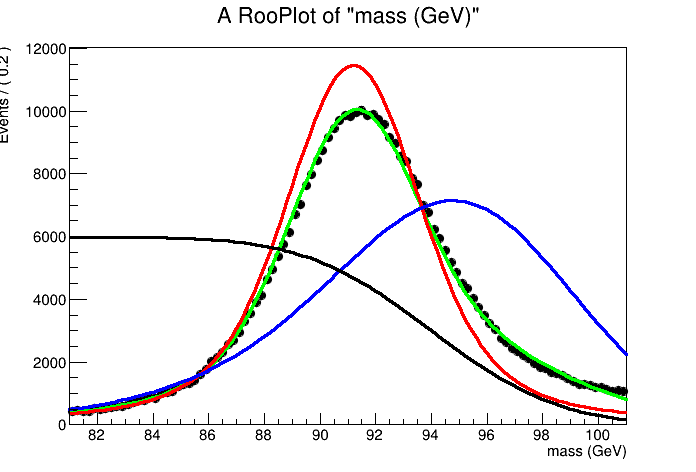

In [8]:
# file.w.pdf("Voigtian_ggh_All").plotOn(frame)

file.w.data("data_Zfit_no_e_cut_UL_calib_cat20").plotOn(frame)
model3.plotOn(frame, rt.RooFit.LineColor(rt.kGreen))
model1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
model2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))
model2_2.plotOn(frame, rt.RooFit.LineColor(rt.kBlack))

# dummy_bkg_var.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))

frame.Draw()
canvas.Update()
canvas.Draw()
